# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [ ]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...
1849,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

1. El conjunto de datos se trata de información de clientes del banco que aplicaron y se les dió un crédito. Consta de 1854 entradas, una por cliente y cada fila con 12 columnas, donde cada columna es una variable a evaluar. 

2. La variable objetivo que se intenta predecir es una variable binaria (BAD) que asume el valor 0 si el aplicante logró pagar el crédito que se le otorgó y 1 si no pudo pagarlo.
    
    - TARGET  :1 = el cliente no pagó el crédito - 0 = el cliente pagó el crédito
    

3. Los atributos disponibles para la predicción son los siguientes:

    - LOAN    Monto del préstamo solicitado
    - MORTDUE Monto adeudado por hipoteca existente
    - VALUE   Valor de la propiedad actual
    - YOJ     Años en el trabajo actual
    - DEROG   Mayor número de informes derogatorios
    - DELINQ  Número de líneas de crédito morosas
    - CLAGE   Edad de la línea de crédito más antigua en meses
    - NINQ    Número de líneas de credito recientes
    - CLNO    Número de líneas de crédito
    - DEBTINC Relación deuda-ingresos
    
    
    
4. Consideramos más determinantes para la predicción al monto adeudado por hipoteca existente (MORTDUE), la relación deuda-ingreso (DEBTINC), el número de líneas de crédito morosas (DELINQ), el monto del préstamo solicitado (LOAN) y el mayor número de informes derogatorios (DEROG).

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [ ]:
def print_metrics(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):0.4}")
    print(f"Precision: {precision_score(y_true, y_pred):0.4}")
    print(f"Recall: {recall_score(y_true, y_pred):0.4}")
    print(f"F1: {f1_score(y_true, y_pred):0.4}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred),"\n\n")

def print_confusion_matrix(clf, X_train, y_train, X_test, y_test):
  fig, axs = plt.subplots(1,2,figsize=(10,5))
  fig.suptitle('Matrices de confusión')
  axs[0].title.set_text('Entrenamiento')
  axs[1].title.set_text('Evaluación')
  fig.tight_layout(pad=5.0)

  p1=plot_confusion_matrix(clf, X_train, y_train, ax=axs[0], cmap=plt.cm.Blues, values_format='d')
  p2=plot_confusion_matrix(clf, X_test, y_test, ax=axs[1], cmap=plt.cm.Blues, values_format='d')

# Normalizamos los datos ya que el algoritmo SGD es sensible al escalamiento de los atributos (feature scaling)
sgd_train = make_pipeline(StandardScaler(), SGDClassifier(random_state=0))
sgd_train.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=0,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

<br>

###Métricas del modelo con parámetros por defecto

Metricas sobre el conjunto de entrenamiento:
Accuracy: 0.8732
Precision: 0.7143
Recall: 0.4183
F1: 0.5276
Confusion matrix:
 [[1190   42]
 [ 146  105]] 


Metricas sobre el conjunto de evaluación:
Accuracy: 0.8679
Precision: 0.6452
Recall: 0.3448
F1: 0.4494
Confusion matrix:
 [[302  11]
 [ 38  20]] 




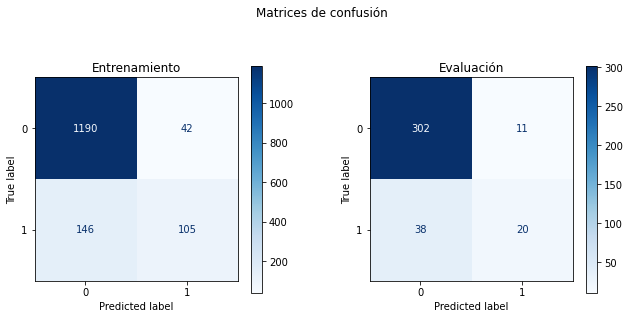

In [ ]:
y_train_pred = sgd_train.predict(X_train)
print("Metricas sobre el conjunto de entrenamiento:")
print_metrics(y_train, y_train_pred)


y_test_pred = sgd_train.predict(X_test)
print("Metricas sobre el conjunto de evaluación:")
print_metrics(y_test, y_test_pred)

print_confusion_matrix(sgd_train, X_train, y_train, X_test, y_test)

<br>

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
param_grid = {
    'sgdclassifier__learning_rate': ('constant','optimal','invscaling','adaptive'),
    'sgdclassifier__loss': ('hinge', 'log', 'modified_huber','squared_hinge','perceptron'),
    'sgdclassifier__penalty': ('l1', 'l2', 'elasticnet'), # Término de regularización
    'sgdclassifier__alpha': (0.1, 0.01, 0.001, 0.0001),   # Tasa de regularización
    'sgdclassifier__eta0':  (0.1, 0.01, 0.001, 0.0001),   # Tasa de entrenamiento
}

with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  model=make_pipeline(StandardScaler(), SGDClassifier(random_state=0))
  cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
  cv.fit(X_train, y_train)
cv

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('sgdclassifier',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
          

<br>

###Métricas del modelo con parámetros personalizados

In [ ]:
def beautify_results(df):
    df.columns = [re.sub('param_(sgdclassifier__)*', '', x) for x in df.columns.values]
    df.std_test_score=df.std_test_score**2
    df.rename(columns={'mean_test_score': 'mean_accuracy', 'std_test_score': 'variance', 'rank_test_score': 'rank'}, inplace = True)

df=pd.DataFrame(cv.cv_results_)
beautify_results(df)
display(df[['alpha','eta0','learning_rate','loss','penalty','mean_accuracy','variance','rank']].sort_values(by='rank').head(10))

,alpha,eta0,learning_rate,loss,penalty,mean_accuracy,variance,rank
781,0.0001,0.01,constant,hinge,l2,0.871886,0.000049,1
585,0.001,0.01,adaptive,hinge,l1,0.871208,0.000084,2
765,0.0001,0.1,adaptive,hinge,l1,0.871208,0.000084,2
527,0.001,0.1,adaptive,hinge,elasticnet,0.871208,0.000084,2
525,0.001,0.1,adaptive,hinge,l1,0.871208,0.000084,2
768,0.0001,0.1,adaptive,log,l1,0.870539,0.000129,6
770,0.0001,0.1,adaptive,log,elasticnet,0.870539,0.000129,6
769,0.0001,0.1,adaptive,log,l2,0.870539,0.000129,6
783,0.0001,0.01,constant,log,l1,0.870539,0.000138,6
785,0.0001,0.01,constant,log,elasticnet,0.870539,0.000138,6


<br>

###Mejor estimador encontrado

In [ ]:
print("Mejor estimador:\n",cv.best_estimator_,"\n")
print("Mejor resultado:\n",cv.best_score_,"\n")


Mejor estimador:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.01,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='constant', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=0,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False) 

Mejor resultado:
 0.8718855218855219 




<br>

###Evaluamos el modelo usando el mejor estimador

Metricas sobre el conjunto de entrenamiento:
Accuracy: 0.8719
Precision: 0.8765
Recall: 0.2829
F1: 0.4277
Confusion matrix:
 [[1222   10]
 [ 180   71]] 


Metricas sobre el conjunto de evaluación:
Accuracy: 0.8841
Precision: 0.9412
Recall: 0.2759
F1: 0.4267
Confusion matrix:
 [[312   1]
 [ 42  16]] 




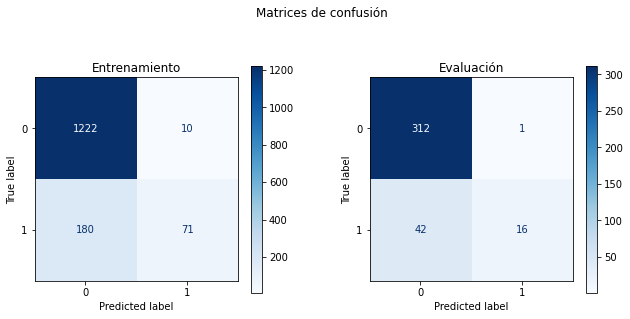

In [ ]:
y_train_pred = cv.predict(X_train)
print("Metricas sobre el conjunto de entrenamiento:")
print_metrics(y_train, y_train_pred)

y_test_pred = cv.predict(X_test)
print("Metricas sobre el conjunto de evaluación:")
print_metrics(y_test, y_test_pred)

print_confusion_matrix(cv, X_train, y_train,X_test, y_test)

<br>

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [ ]:
clf=DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

<br>

###Métricas del modelo con parámetros por defecto

Metricas sobre el conjunto de entrenamiento: 

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
Confusion matrix:
 [[1232    0]
 [   0  251]] 


Metricas sobre el conjunto de evaluación:
Accuracy: 0.8814
Precision: 0.6167
Recall: 0.6379
F1: 0.6271
Confusion matrix:
 [[290  23]
 [ 21  37]] 




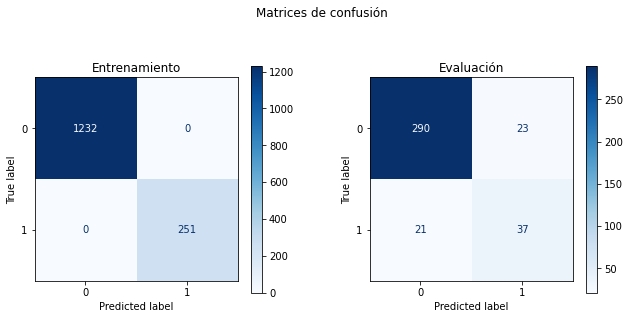

In [ ]:
y_train_pred = clf.predict(X_train)
print('Metricas sobre el conjunto de entrenamiento: \n')
print_metrics(y_train, y_train_pred)

y_test_pred = clf.predict(X_test)
print("Metricas sobre el conjunto de evaluación:")
print_metrics(y_test, y_test_pred)

print_confusion_matrix(clf, X_train, y_train,X_test, y_test)

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4,5,6,7,8,9,10,11,12,13],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,15],
    'splitter': ['best','random'],
    'max_features': ['auto', 'sqrt', 'log2', None, 2, 3, 5, 7, 9],
}

model=DecisionTreeClassifier(random_state=0)
cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
cv.fit(X_train, y_train)
cv

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12,

<br>

###Métricas del modelo con parámetros personalizados

In [ ]:
df=pd.DataFrame(cv.cv_results_)
beautify_results(df)
df[['criterion','splitter','max_depth','max_features','min_samples_leaf','mean_accuracy','variance','rank']].sort_values(by='rank').head(10)

,criterion,splitter,max_depth,max_features,min_samples_leaf,mean_accuracy,variance,rank
1004,gini,best,7,9,13,0.889433,0.000339,1
746,gini,best,6,9,10,0.889410,0.000116,2
2128,gini,best,12,2,1,0.888746,0.000172,3
1002,gini,best,7,9,12,0.888077,0.000122,4
4509,entropy,random,11,9,1,0.888070,0.000337,5
750,gini,best,6,9,12,0.888065,0.000311,6
492,gini,best,5,9,9,0.888065,0.000093,6
1989,gini,random,11,9,1,0.887403,0.000209,8
494,gini,best,5,9,10,0.887396,0.000056,9
672,gini,best,6,5,1,0.887396,0.000106,10


<br>

###Mejor estimador encontrado

In [ ]:
print("Mejor estimador:\n",cv.best_estimator_,"\n")
print("Mejor resultado:\n",cv.best_score_,"\n")


Mejor estimador:
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best') 

Mejor resultado:
 0.8894326144326146 




<br>

###Evaluamos el modelo usando el mejor estimador

Metricas sobre el conjunto de entrenamiento: 

Accuracy: 0.9096
Precision: 0.8545
Recall: 0.5618
F1: 0.6779
Confusion matrix:
 [[1208   24]
 [ 110  141]] 


Metricas sobre el conjunto de evaluación:
Accuracy: 0.9057
Precision: 0.7674
Recall: 0.569
F1: 0.6535
Confusion matrix:
 [[303  10]
 [ 25  33]] 




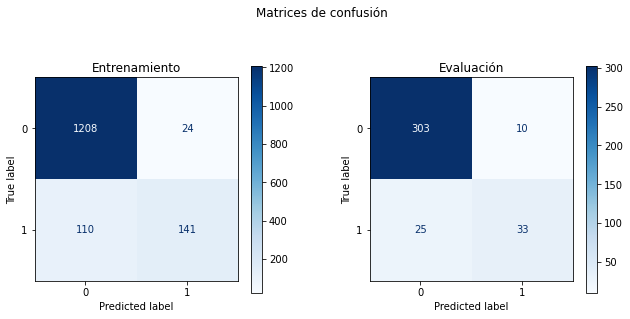

In [ ]:
y_train_pred = cv.predict(X_train)
print('Metricas sobre el conjunto de entrenamiento: \n')
print_metrics(y_train, y_train_pred)

y_test_pred = cv.predict(X_test)
print("Metricas sobre el conjunto de evaluación:")
print_metrics(y_test, y_test_pred)

print_confusion_matrix(cv, X_train, y_train, X_test, y_test,)


<br>

###Árbol con mejor resultado

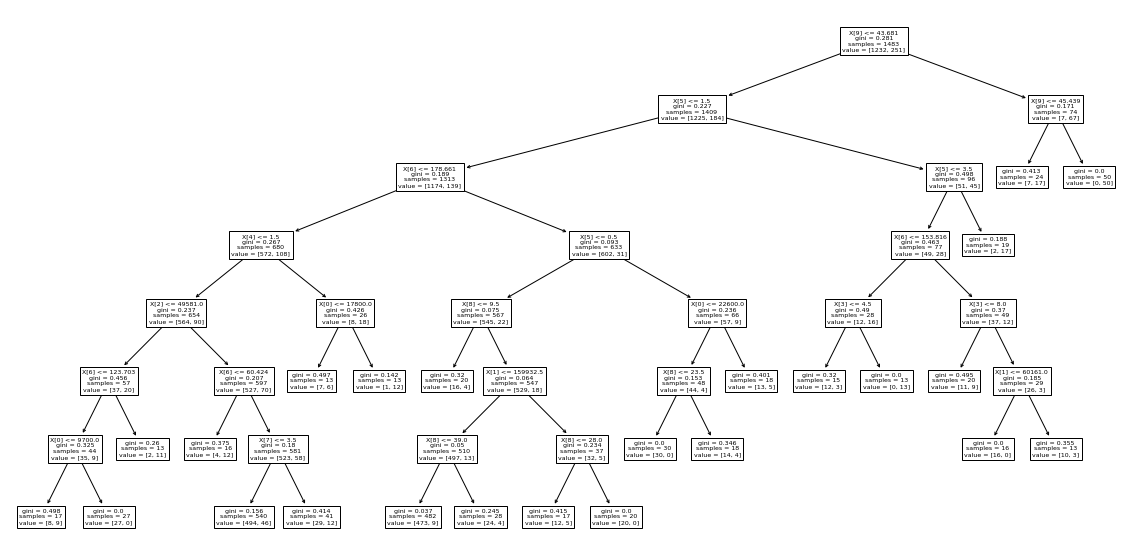

In [ ]:
plt.figure(figsize=(20,10))
t=plot_tree(cv.best_estimator_)

<br>

##Conclusiones

#### Respecto a la clasificación lineal usando SGD, si bien con los datos de entrenamiento la Accuracy es casi la misma usando los hiperparámetros por defecto (0.8732) contra los personalizados (0.8719), se observa una mejora en el resultado de los parámetros personalizados al aplicarlos sobre los datos de evaluación: 0.8841 contra 0.8679 de los parámetros por defecto.
<br>

#### Respecto a la clasificación usando árboles de decisión, se observa que los datos de entrenamiento tuvieron overfitting utilizando los atributos por defecto dando una Accuracy de 1.0 contra 0.9096 con los parámetros personalizados. Viendo las métricas sobre los datos de evaluación se aprecia nuevamente que utilizando los parámetros personalizados se logró una mayor Accuracy (0.9057) respecto a utilizar los parámetros por defecto (0.8814).
<br>

#### Finalmenete se concluye que se obtiene una mejor clasificación utilizando el modelo de árboles de decisión sobre el SGD ya que fueron superiores incluso al utilizar los parámetros por defecto.